
1. Import and clean the data: Handle missing values, remove duplicates and format the data in a way that is easy to work with.

2. Describe the data: Obtain basic statistics such as mean, median, standard deviation, etc. to get a general understanding of the data.

3. Visualize the data: Use different types of plots such as histograms, bar plots, scatter plots, etc. to gain insights into the data and identify any patterns or relationships.

4. Analyze the distributions: Check if the variables are normally distributed, positively or negatively skewed, etc.

5. Check for outliers: Identify any outliers and determine if they should be removed or transformed.

6. Correlation: Find the relationship between different variables and determine if there is any correlation between them.

7. Hypothesis testing: Test any assumptions or hypotheses about the data.

8. Summarize findings: Draw conclusions from the EDA and provide insights into the data.

# Imports

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import catboost
pd.options.display.max_rows = None
pd.options.display.max_columns = None
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor


# Load data

In [47]:
# Loading data
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
df = train



### Check if there are any duplicate rows and if so remove them.

### No duplicate rows

In [48]:
print(df.shape)
print(df.drop_duplicates().shape)

print(test.shape)
print(test.drop_duplicates().shape)

(1460, 81)
(1460, 81)
(1459, 80)
(1459, 80)


### Drop id column since its irrelevant

In [49]:
df.drop(["Id"],inplace=True,axis=1)
test.drop(["Id"],inplace=True,axis=1)


### Check for missing values

# Print column names where there is atleast 1 missing value sorted by increasing number of missing values


In [50]:
# Get a Boolean DataFrame indicating missing values
missing_values = df.isna().any()

# Get the columns that have missing values

# Get the count of missing values per column
missing_values_count = df.isna().sum()

# Get the columns that have missing values and sort by number of missing values
columns_with_missing_values = missing_values_count[missing_values].sort_values().index.tolist()


for column in columns_with_missing_values:
    count = missing_values_count[column]
    print(f'"{column}" has {count} missing value(s).')

"Electrical" has 1 missing value(s).
"MasVnrType" has 8 missing value(s).
"MasVnrArea" has 8 missing value(s).
"BsmtQual" has 37 missing value(s).
"BsmtCond" has 37 missing value(s).
"BsmtFinType1" has 37 missing value(s).
"BsmtExposure" has 38 missing value(s).
"BsmtFinType2" has 38 missing value(s).
"GarageCond" has 81 missing value(s).
"GarageQual" has 81 missing value(s).
"GarageFinish" has 81 missing value(s).
"GarageType" has 81 missing value(s).
"GarageYrBlt" has 81 missing value(s).
"LotFrontage" has 259 missing value(s).
"FireplaceQu" has 690 missing value(s).
"Fence" has 1179 missing value(s).
"Alley" has 1369 missing value(s).
"MiscFeature" has 1406 missing value(s).
"PoolQC" has 1453 missing value(s).


### "Electrical" column is categorical.

### In order to deceide how to handle the missing value in "Electrical": 

### Check if "Electrical" has any other categorical column with perfect correlation


### OUTCOME: Seems like it is not correlated with other columns. Also tried looking at numerical columns and did not find anything interesting

In [51]:
categorical_columns = df.select_dtypes(include='object').columns
for column in categorical_columns:
    if column != "Electrical":
        print(column)
        print(df[["Electrical",column]].sort_values(by="Electrical")[:20])

MSZoning
     Electrical MSZoning
729       FuseA       RM
328       FuseA       RL
1150      FuseA       RL
339       FuseA       RL
342       FuseA       RL
1144      FuseA       RL
347       FuseA       RL
1136      FuseA       RL
365       FuseA       RM
307       FuseA       RM
1122      FuseA       RL
1119      FuseA       RL
375       FuseA       RL
1112      FuseA       RL
393       FuseA       RL
394       FuseA       RL
406       FuseA       RL
1090      FuseA       RL
410       FuseA       RL
1120      FuseA       RM
Street
     Electrical Street
729       FuseA   Pave
328       FuseA   Pave
1150      FuseA   Pave
339       FuseA   Pave
342       FuseA   Pave
1144      FuseA   Pave
347       FuseA   Pave
1136      FuseA   Pave
365       FuseA   Pave
307       FuseA   Pave
1122      FuseA   Pave
1119      FuseA   Pave
375       FuseA   Pave
1112      FuseA   Pave
393       FuseA   Pave
394       FuseA   Pave
406       FuseA   Pave
1090      FuseA   Pave
410       FuseA   Pave

### Look at the row

In [52]:
row = df.loc[1379]
print(row)

MSSubClass            80
MSZoning              RL
LotFrontage         73.0
LotArea             9735
Street              Pave
Alley                NaN
LotShape             Reg
LandContour          Lvl
Utilities         AllPub
LotConfig         Inside
LandSlope            Gtl
Neighborhood      Timber
Condition1          Norm
Condition2          Norm
BldgType            1Fam
HouseStyle          SLvl
OverallQual            5
OverallCond            5
YearBuilt           2006
YearRemodAdd        2007
RoofStyle          Gable
RoofMatl         CompShg
Exterior1st      VinylSd
Exterior2nd      VinylSd
MasVnrType          None
MasVnrArea           0.0
ExterQual             TA
ExterCond             TA
Foundation         PConc
BsmtQual              Gd
BsmtCond              TA
BsmtExposure          No
BsmtFinType1         Unf
BsmtFinSF1             0
BsmtFinType2         Unf
BsmtFinSF2             0
BsmtUnfSF            384
TotalBsmtSF          384
Heating             GasA
HeatingQC             Gd


### Set electrical value for the mode of neighborhood

In [53]:
most_common_in_neigh = df[(df['Neighborhood'] == row['Neighborhood'])]["Electrical"].value_counts().index[0]
df.loc[1379, 'Electrical']  = most_common_in_neigh

### Next we move to 'MasVnrType' and 'MasVnrArea'. The missing values for these are the same rows ( since if mason type is NaN also its area is NaN).
### After short inspection at the neighborhood of each of the rows where these are missing, I concluded it is likely that these houses have no mason, and will set the values to None and 0

In [54]:

mask = df['MasVnrType'].isna()
nan_rows = df[mask].index

df.loc[nan_rows,'MasVnrType'] = "None"

df.loc[nan_rows,'MasVnrArea'] = 0


#### The remainings features except for "LotFrontage" contain NaN values because they represent a qualitative measurement of a property that doesn't exist. For instance, if a row has a value of 0 for 'Fireplaces', then 'FireplaceQu' will also be NaN. To make it easier to work with the data later, I've converted all these NaN values to the string "Na".

In [55]:
# Get a Boolean DataFrame indicating missing values
missing_values = df.isna().any()

# Get the columns that have missing values

# Get the count of missing values per column
missing_values_count = df.isna().sum()

# Get the columns that have missing values and sort by number of missing values
columns_with_missing_values = missing_values_count[missing_values].sort_values().index.tolist()


for col in columns_with_missing_values: # columns related to garage and basement
    if col != 'LotFrontage':
        df[col].fillna("Na", inplace=True)


### Looking at the correlations , i see 'LotFrontage' has high corrleation with Sale price and therefore should be treated carefully when filling NaNs

### Consider for later to create a model that predicts 'LotFrontage' based on other features

In [56]:
corr = df.corr()
corr[1:2]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
LotFrontage,-0.386347,1.0,0.426095,0.251646,-0.059213,0.123349,0.088866,0.192411,0.233633,0.0499,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.26317,-0.006069,0.352096,0.266639,0.285691,0.344997,0.088521,0.151972,0.0107,0.070029,0.041383,0.206167,0.003368,0.0112,0.00745,0.351799


### Looking at mean LotFrontage and std suggests I can use the mean of each neighborhood as a simple baseline.
### However this is a simple approximation and should be improved later

              mean_lotfrontage  std_lotfrontage
Neighborhood                                   
Blmngtn              47.142857         0.356222
Blueste              24.000000              NaN
BrDale               21.562500         1.771925
BrkSide              57.509804         4.154470
ClearCr              83.461538         2.155355
CollgCr              71.682540         0.826432
Crawfor              71.804878         0.697890
Edwards              68.217391         4.942113
Gilbert              79.877551         1.660707
IDOTRR               62.500000         1.786505
MeadowV              27.800000         0.883700
Mitchel              70.083333         0.136043
NAmes                76.462366         6.113164
NPkVill              32.285714         1.229634
NWAmes               81.288889        -0.869588
NoRidge              91.878788         1.449825
NridgHt              81.881579        -0.565795
OldTown              62.788991         1.853366
SWISU                58.913043         3

Text(0.5, 1.0, 'Histogram of LotFrontage')

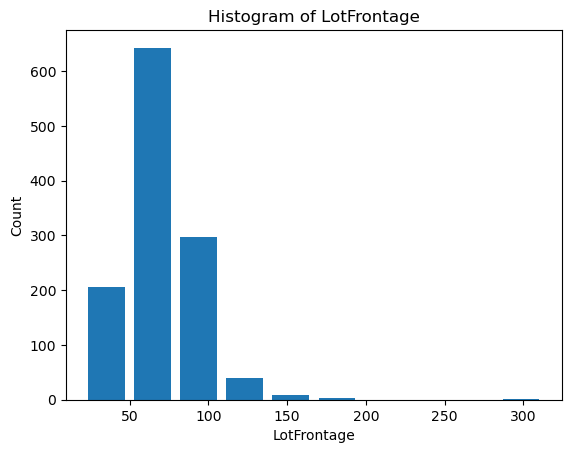

In [57]:
df.loc[ :,['LotFrontage','Street']]


# Calculate the mean of 'LotFrontage' by 'Street'
mean_lotfrontage_by_street = df.groupby('Neighborhood')['LotFrontage'].mean()
std_lotfrontage_by_street = df.groupby('Neighborhood')['LotFrontage'].skew()

result = pd.concat([mean_lotfrontage_by_street, std_lotfrontage_by_street], axis=1)
result.columns = ['mean_lotfrontage', 'std_lotfrontage']
print(result)

df['LotFrontage'].plot.hist(bins=10, rwidth=0.8)

# add labels and title
plt.xlabel('LotFrontage')
plt.ylabel('Count')
plt.title('Histogram of LotFrontage')



In [58]:
df['LotFrontage'].fillna(df.groupby('Neighborhood')['LotFrontage'].transform('mean'), inplace=True)

### Lets remove highly correlated features to simplify the problem

In [59]:
high_corr = df.corr()[df.corr().abs() > 0.8]

# select values not equal to NaN and below 1
mask = (high_corr .notna()).any(axis=1)
result = high_corr .loc[mask].stack().reset_index()
result.columns = ['index', 'column', 'value']
result = result.drop(result[result['value'] == 1].index)
# print result
print(result)


           index        column     value
12   TotalBsmtSF      1stFlrSF  0.819530
13      1stFlrSF   TotalBsmtSF  0.819530
18     GrLivArea  TotRmsAbvGrd  0.825489
25  TotRmsAbvGrd     GrLivArea  0.825489
29    GarageCars    GarageArea  0.882475
30    GarageArea    GarageCars  0.882475


In [60]:
df.drop(["GarageYrBlt",'1stFlrSF','GarageArea','TotRmsAbvGrd'],axis=1,inplace=True)

## Some visualization

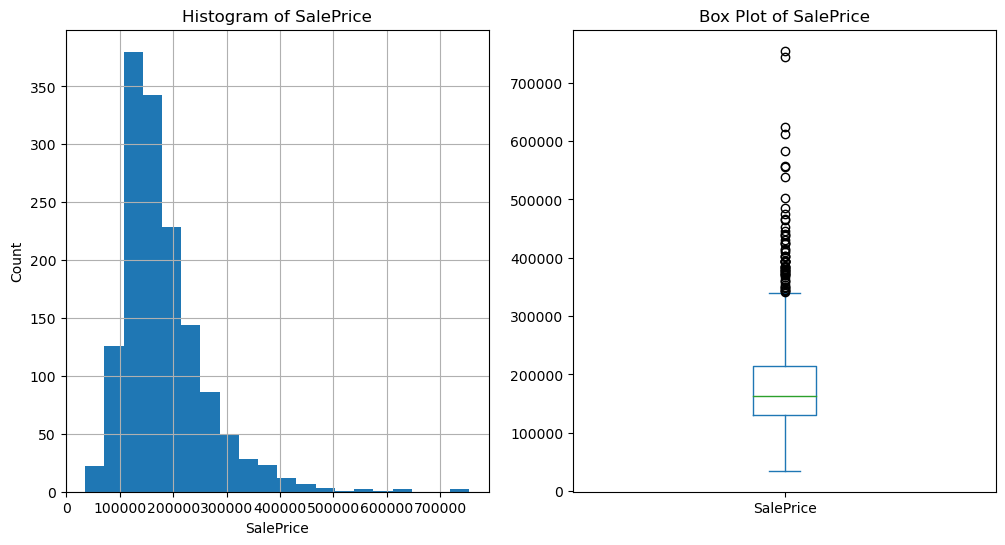

In [61]:
import matplotlib.pyplot as plt
import pandas as pd

# create sample dataframe
# create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# plot histogram
df["SalePrice"].hist(bins=20, ax=ax1)

# add labels and title for histogram
ax1.set_xlabel('SalePrice')
ax1.set_ylabel('Count')
ax1.set_title('Histogram of SalePrice')

# plot box plot
df['SalePrice'].plot.box(vert=True, ax=ax2)

# add labels and title for box plot

ax2.set_title('Box Plot of SalePrice')

# show plot
plt.show()


### Drop features with less than 10% correlation to SalePrice

In [62]:
corr = df.corr()

# drop columns with absolute correlation below 0.1
columns_to_drop = [col for col in corr.columns if abs(corr.loc['SalePrice', col]) < 0.1]
df = df.drop(columns=columns_to_drop)

diff = set(df.columns).symmetric_difference(set(train.columns))

# print columns not in both dataframes
print('Columns Dropped', diff)

Columns Dropped {'MoSold', '3SsnPorch', 'OverallCond', 'BsmtFinSF2', 'MSSubClass', 'LowQualFinSF', 'PoolArea', 'BsmtHalfBath', 'YrSold', 'MiscVal'}


### Looking into outliers, not sure what to do with them. for now leave it as is.

In [63]:
# df = df.sort_values(by='SalePrice', ascending=False)

# extract the top 5 rows based on the "SalePrice" column
top_5 = df.sort_values(by='SalePrice', ascending=False).nlargest(5, 'SalePrice')

# print the rows with the top 5 highest values in the "SalePrice" column
top_5

,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
691,RL,104.0,21535,Pave,Na,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,989,2444,GasA,Ex,Y,SBrkr,1872,4316,0,3,1,4,1,Ex,Typ,2,Ex,Attchd,Fin,3,TA,TA,Y,382,50,0,0,Na,Na,Na,WD,Normal,755000
1182,RL,160.0,15623,Pave,Na,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,300,2396,GasA,Ex,Y,SBrkr,2065,4476,1,3,1,4,1,Ex,Typ,2,TA,Attchd,Fin,3,TA,TA,Y,171,78,0,0,Ex,MnPrv,Na,WD,Abnorml,745000
1169,RL,118.0,35760,Pave,Na,IR1,Lvl,AllPub,CulDSac,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,1995,1996,Hip,CompShg,HdBoard,HdBoard,BrkFace,1378.0,Gd,Gd,PConc,Ex,TA,Gd,GLQ,1387,Unf,543,1930,GasA,Ex,Y,SBrkr,1796,3627,1,3,1,4,1,Gd,Typ,1,TA,Attchd,Fin,3,TA,TA,Y,361,76,0,0,Na,Na,Na,WD,Normal,625000
898,RL,100.0,12919,Pave,Na,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,2009,2010,Hip,CompShg,VinylSd,VinylSd,Stone,760.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2188,Unf,142,2330,GasA,Ex,Y,SBrkr,0,2364,1,2,1,2,1,Ex,Typ,2,Gd,Attchd,Fin,3,TA,TA,Y,0,67,0,0,Na,Na,Na,New,Partial,611657
803,RL,107.0,13891,Pave,Na,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,2008,2009,Hip,CompShg,VinylSd,VinylSd,Stone,424.0,Ex,TA,PConc,Ex,TA,Gd,Unf,0,Unf,1734,1734,GasA,Ex,Y,SBrkr,1088,2822,0,3,1,4,1,Ex,Typ,1,Gd,BuiltIn,RFn,3,TA,TA,Y,52,170,0,192,Na,Na,Na,New,Partial,582933


### Moving on to handle missing value in test set
#### first lets see which columns have missing values

In [64]:
# Get a Boolean DataFrame indicating missing values
missing_values = test.isna().any()

# Get the columns that have missing values

# Get the count of missing values per column
missing_values_count = test.isna().sum()

# Get the columns that have missing values and sort by number of missing values
columns_with_missing_values = missing_values_count[missing_values].sort_values().index.tolist()


for column in columns_with_missing_values:
    count = missing_values_count[column]
    print(f'"{column}" has {count} missing value(s).')

"TotalBsmtSF" has 1 missing value(s).
"GarageArea" has 1 missing value(s).
"GarageCars" has 1 missing value(s).
"KitchenQual" has 1 missing value(s).
"BsmtUnfSF" has 1 missing value(s).
"BsmtFinSF2" has 1 missing value(s).
"BsmtFinSF1" has 1 missing value(s).
"SaleType" has 1 missing value(s).
"Exterior1st" has 1 missing value(s).
"Exterior2nd" has 1 missing value(s).
"Functional" has 2 missing value(s).
"Utilities" has 2 missing value(s).
"BsmtHalfBath" has 2 missing value(s).
"BsmtFullBath" has 2 missing value(s).
"MSZoning" has 4 missing value(s).
"MasVnrArea" has 15 missing value(s).
"MasVnrType" has 16 missing value(s).
"BsmtFinType2" has 42 missing value(s).
"BsmtFinType1" has 42 missing value(s).
"BsmtQual" has 44 missing value(s).
"BsmtExposure" has 44 missing value(s).
"BsmtCond" has 45 missing value(s).
"GarageType" has 76 missing value(s).
"GarageFinish" has 78 missing value(s).
"GarageQual" has 78 missing value(s).
"GarageCond" has 78 missing value(s).
"GarageYrBlt" has 78 

### Took a look at the row where GarageArea/TotalBsmtSF == NaN. Seems like this house just didn't have a basement , so im changing this to 0.  

### This assumption may be wrong.

In [65]:
test[test.TotalBsmtSF.isna()]


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
660,20,RM,99.0,5940,Pave,NaN,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,4,2008,ConLD,Abnorml


In [66]:
test.loc[660,"TotalBsmtSF"] = 0
test.loc[660,"BsmtUnfSF"] = 0
test.loc[660,"BsmtFinSF1"] = 0
test.loc[660,"BsmtFinSF2"] = 0
test.loc[1116,"GarageArea"] = 0
test.loc[1116,"GarageCars"] = 0

### Took a look at the row where KitchenQual == NaN. Seems like this house didn't have a kitchen , so im changing this to "Po" - poor.  

### This assumption may be wrong.

In [67]:
test.loc[95,"KitchenQual"] = "Po"

### Looking at missing SaleType. unsure what Saletype could be correlated to, so ill give it the mode of the dataset.

In [68]:
test[test.SaleType.isna()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1029,20,RL,85.0,13770,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Sawyer,Feedr,Norm,1Fam,1Story,5,6,1958,1998,Gable,CompShg,Plywood,Plywood,BrkFace,340.0,TA,TA,CBlock,TA,TA,Mn,Rec,190.0,BLQ,873.0,95.0,1158.0,GasA,TA,Y,SBrkr,1176,0,0,1176,1.0,0.0,1,0,3,1,TA,6,Typ,2,Gd,Attchd,1958.0,Unf,1.0,303.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,10,2007,NaN,Normal


In [69]:
mode = test.SaleType.mode()[0]
test.loc[1029,"SaleType"] = mode

### Row with Exterior1st/2nd = NaN changed to "Other".

In [70]:
test[test.Exterior1st.isna()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
691,30,RL,85.0,19550,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1940,2007,Flat,Tar&Grv,NaN,NaN,None,0.0,TA,TA,PConc,TA,TA,Gd,ALQ,1035.0,Unf,0.0,545.0,1580.0,GasA,Ex,Y,SBrkr,1518,0,0,1518,1.0,0.0,1,0,2,1,Fa,5,Typ,2,Gd,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,39,0,0,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal


In [71]:
test.loc[691,"Exterior1st"] = "Other"
test.loc[691,"Exterior2nd"] = "Other"

### BsmtHalfBath/FullBath changed to 0

In [72]:
test[test.BsmtFullBath.isna()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
660,20,RM,99.0,5940,Pave,NaN,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,4,2008,ConLD,Abnorml
728,20,RL,123.0,47007,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1959,1996,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,Y,SBrkr,3820,0,0,3820,NaN,NaN,3,1,5,1,Ex,11,Typ,2,Gd,Attchd,1959.0,Unf,2.0,624.0,TA,TA,Y,0,372,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal


In [73]:
test.loc[660,"BsmtHalfBath"] = 0
test.loc[728,"BsmtHalfBath"] = 0
test.loc[660,"BsmtFullBath"] = 0
test.loc[728,"BsmtFullBath"] = 0

### Both rows with "Functional" == NaN were soled under Abnormal condition, so ill assume functionally was Salvage only ("Sal")

In [74]:
test[test.Functional.isna()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
756,20,NaN,80.0,14584,Pave,NaN,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,NaN,0,NaN,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Abnorml
1013,50,RM,60.0,10320,Pave,Grvl,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,4,1,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0.0,Unf,0.0,771.0,771.0,GasA,Fa,Y,SBrkr,866,504,114,1484,0.0,0.0,2,0,3,1,TA,6,NaN,0,NaN,Detchd,1910.0,Unf,1.0,264.0,TA,Fa,N,14,211,0,0,84,0,NaN,NaN,NaN,0,9,2007,COD,Abnorml


In [75]:
test.loc[756,"Functional"] = "Sal"
test.loc[1013,"Functional"] = "Sal"

### For Utilities = NaN ill assume to lowest grade "ELO"

In [76]:
test[test.Utilities.isna()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
455,30,NaN,109.0,21780,Grvl,NaN,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,NaN,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,NaN,NaN,NaN,0,3,2009,ConLD,Normal
485,20,RL,NaN,31220,Pave,NaN,IR1,Bnk,NaN,FR2,Gtl,Gilbert,Feedr,Norm,1Fam,1Story,6,2,1952,1952,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1632.0,1632.0,GasA,TA,Y,FuseA,1474,0,0,1474,0.0,0.0,1,0,3,1,TA,7,Min2,2,Gd,Attchd,1952.0,Unf,2.0,495.0,TA,TA,Y,0,0,144,0,0,0,NaN,NaN,Shed,750,5,2008,WD,Normal


In [77]:
test.loc[455,"Utilities"] = "ELO"
test.loc[485,"Utilities"] = "ELO"

### Decieded to handle missing MSZoning by mode of Neighborhood

In [78]:
test[test.MSZoning.isna()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
455,30,NaN,109.0,21780,Grvl,NaN,Reg,Lvl,ELO,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,NaN,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,NaN,NaN,NaN,0,3,2009,ConLD,Normal
756,20,NaN,80.0,14584,Pave,NaN,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,Sal,0,NaN,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Abnorml
790,70,NaN,NaN,56600,Pave,NaN,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,5,1,1900,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,686.0,686.0,GasA,Ex,Y,SBrkr,1150,686,0,1836,0.0,0.0,2,0,4,1,TA,7,Maj1,0,NaN,Detchd,1900.0,Unf,1.0,288.0,TA,Fa,N,0,0,0,0,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal
1444,20,NaN,125.0,31250,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,1,3,1951,1951,Gable,CompShg,CBlock,VinylSd,None,0.0,TA,Fa,CBlock,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,Y,FuseA,1600,0,0,1600,0.0,0.0,1,1,3,1,TA,6,Mod,0,NaN,Attchd,1951.0,Unf,1.0,270.0,Fa,TA,N,0,0,135,0,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal


In [79]:
import pandas as pd


# Group the data by the "Neighborhood" column
grouped = test.groupby("Neighborhood")

# Calculate the mode of the "MSZoning" column for each group
mode = grouped["MSZoning"].apply(lambda x: x.mode()[0])

# Use the mode to fill the NaN values in the "MSZoning" column
test["MSZoning"].fillna(test["Neighborhood"].map(mode), inplace=True)


### Missing MasVnrArea treated as 0

In [80]:
test.loc[test[test.MasVnrArea.isna()].index,"MasVnrArea"] = 0

### Rest of missing features can be treated like the train set

In [81]:
# Get a Boolean DataFrame indicating missing values
missing_values = test.isna().any()

# Get the columns that have missing values

# Get the count of missing values per column
missing_values_count = test.isna().sum()

# Get the columns that have missing values and sort by number of missing values
columns_with_missing_values = missing_values_count[missing_values].sort_values().index.tolist()


for col in columns_with_missing_values: # columns related to garage and basement
    if col != 'LotFrontage':
        test[col].fillna("Na", inplace=True)


test['LotFrontage'].fillna(test.groupby('Neighborhood')['LotFrontage'].transform('mean'), inplace=True)

### Converting non-numeric features
#### First lets look how many non-numeric features there are:

In [82]:

# Create a list of all non-numeric features
non_numeric_features = df.select_dtypes(exclude=["float64", "int64"]).columns

# Print the non-numeric features
print(non_numeric_features)


Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


### Bar plotting all non-numeric features to decide how to number them.

## PLOTTING NON NUMERIC

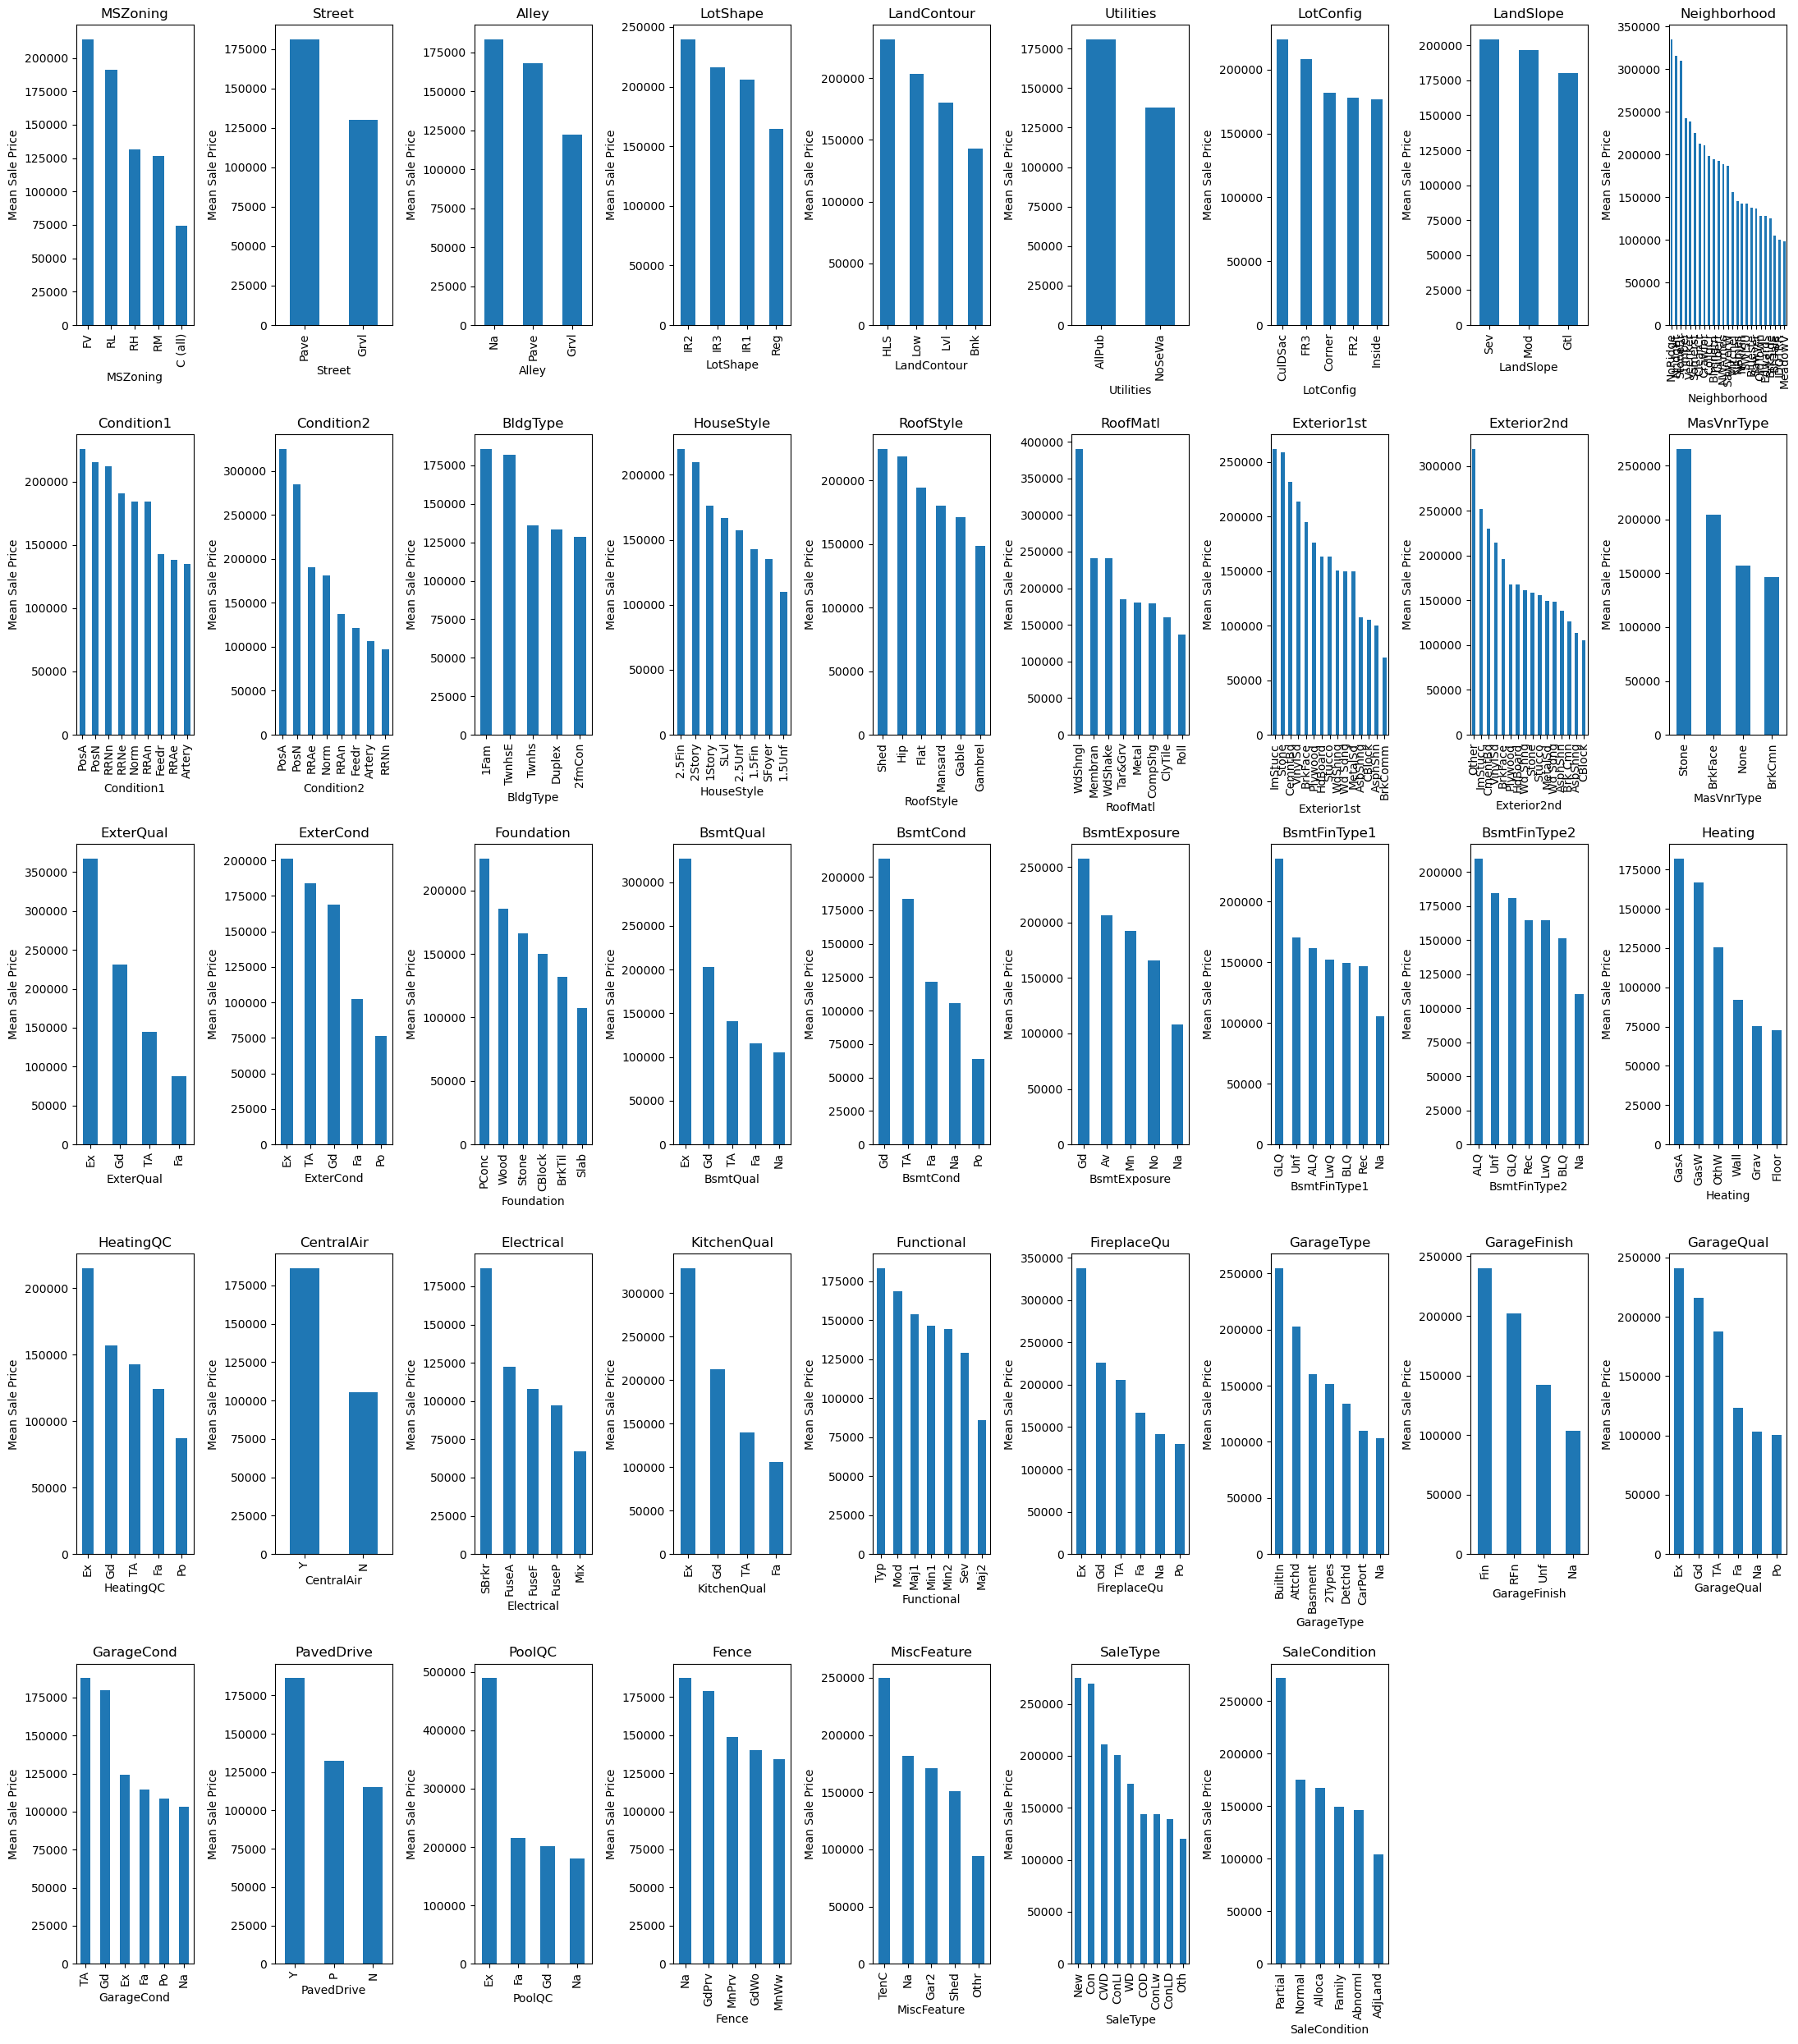

In [86]:


# Group the data by the "MSZoning" column and calculate the mean "SalePrice" value for each group
plt.figure(figsize=(22,25))
for i,col in enumerate(non_numeric_features):
    plt.subplot(5,9,i+1)
    mean_sale_price_by_zoning = df.groupby(col).mean()["SalePrice"]

    # Sort the mean "SalePrice" values in descending order
    mean_sale_price_by_zoning = mean_sale_price_by_zoning.sort_values(ascending=False)

    # Plot the mean "SalePrice" value for each group
    mean_sale_price_by_zoning.plot.bar()

    # Add a title and labels to the x and y axes
    
    plt.title(col)
    plt.ylabel("Mean Sale Price")

plt.tight_layout()
    # Show the plot

### Assaigning values to categories, where the highest value is given to the catergory with highest mean of SalePrice

In [89]:
# iterate over non-numeric columns
for column in df.select_dtypes(exclude=["int", "float"]).columns:
    # calculate correlation between mean of "SalePrice" and each category in the column
    correlations = {
        category: df[df[column] == category]["SalePrice"].mean()
        for category in df[column].unique()
    }
    
    # sort categories by correlation in descending order
    sorted_correlations = {k: v for k, v in sorted(correlations.items(), key=lambda item: item[1], reverse=True)}
 
    # assign values to categories in descending order
    value = 1
    for category in sorted_correlations:
        df.loc[df[column] == category, column] = value
        test.loc[test[column] == category, column] = value
        value += 1


### There are catergories unseen in the train set. need to consider what to do with them

In [105]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# split the data into features (X) and target (y)
X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# initialize the RandomForestRegressor model
for i in range(1,10):
    model = RandomForestRegressor(max_depth=i,n_estimators=1000)

    # fit the model on the training data
    model.fit(X_train, y_train)

    # make predictions on the test data
    y_pred = model.predict(X_test)

    # calculate the mean squared error of the predictions
    mse = np.round(mean_squared_error(y_test, y_pred,squared=False),0)

    print("RMSE:", mse,i)


Mean Squared Error: 58214.0 1
Mean Squared Error: 47158.0 2
Mean Squared Error: 40513.0 3
Mean Squared Error: 35898.0 4
Mean Squared Error: 33133.0 5
Mean Squared Error: 31699.0 6
Mean Squared Error: 31142.0 7


KeyboardInterrupt: 

In [96]:
model = CatBoostRegressor()

# Train the model on the data
model.fit(X_train, y_train)

# Predict the target variable for new data
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", np.sqrt(mse))

Learning rate set to 0.04196
0:	learn: 76350.6451021	total: 5.18ms	remaining: 5.17s
1:	learn: 74431.0830486	total: 11.1ms	remaining: 5.55s
2:	learn: 72431.2663205	total: 17.9ms	remaining: 5.95s
3:	learn: 70486.2355069	total: 24.6ms	remaining: 6.12s
4:	learn: 68706.8798701	total: 29.5ms	remaining: 5.88s
5:	learn: 67005.3118758	total: 33.1ms	remaining: 5.48s
6:	learn: 65495.2830637	total: 36.5ms	remaining: 5.18s
7:	learn: 64047.1674200	total: 40.3ms	remaining: 4.99s
8:	learn: 62573.6363819	total: 45.8ms	remaining: 5.04s
9:	learn: 61130.4269212	total: 49.5ms	remaining: 4.9s
10:	learn: 59748.7107020	total: 52.8ms	remaining: 4.75s
11:	learn: 58188.2671934	total: 56.3ms	remaining: 4.63s
12:	learn: 56779.5165865	total: 59.6ms	remaining: 4.53s
13:	learn: 55441.8215721	total: 66.6ms	remaining: 4.69s
14:	learn: 54250.8243085	total: 69.9ms	remaining: 4.59s
15:	learn: 53101.8879987	total: 73.2ms	remaining: 4.5s
16:	learn: 52049.9395376	total: 76.7ms	remaining: 4.43s
17:	learn: 50888.6537174	total:

## Pretty shitty RMSE, lets try to drop categorical features
### Also bad.

In [98]:
# df_test = test.select_dtypes(exclude=["object"])

# split the data into features (X) and target (y)
X = df.drop("SalePrice", axis=1).select_dtypes(exclude=["object"])
y = df["SalePrice"]
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# initialize the RandomForestRegressor model
model = RandomForestRegressor(max_depth=5)

# fit the model on the training data
model.fit(X_train, y_train)

# make predictions on the test data
y_pred = model.predict(X_test)

# calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", np.sqrt(mse))


Mean Squared Error: 33157.47914494067


In [42]:
train.corr().iloc[-1].nlargest(3304)

['GrLivArea','OverallQual','GarageCars','YearBuilt','TotalBsmtSF','YearRemodAdd','MasVnrArea','LotFrontage']

['GrLivArea',
 'OverallQual',
 'GarageCars',
 'YearBuilt',
 'TotalBsmtSF',
 'YearRemodAdd',
 'MasVnrArea',
 'LotFrontage']

In [43]:
df = train[['GrLivArea','OverallQual','GarageCars','YearBuilt','TotalBsmtSF','YearRemodAdd','MasVnrArea','LotFrontage']]


### Looking into variance of saleprice within neighborhood

Text(0, 0.5, 'std Sale Price')

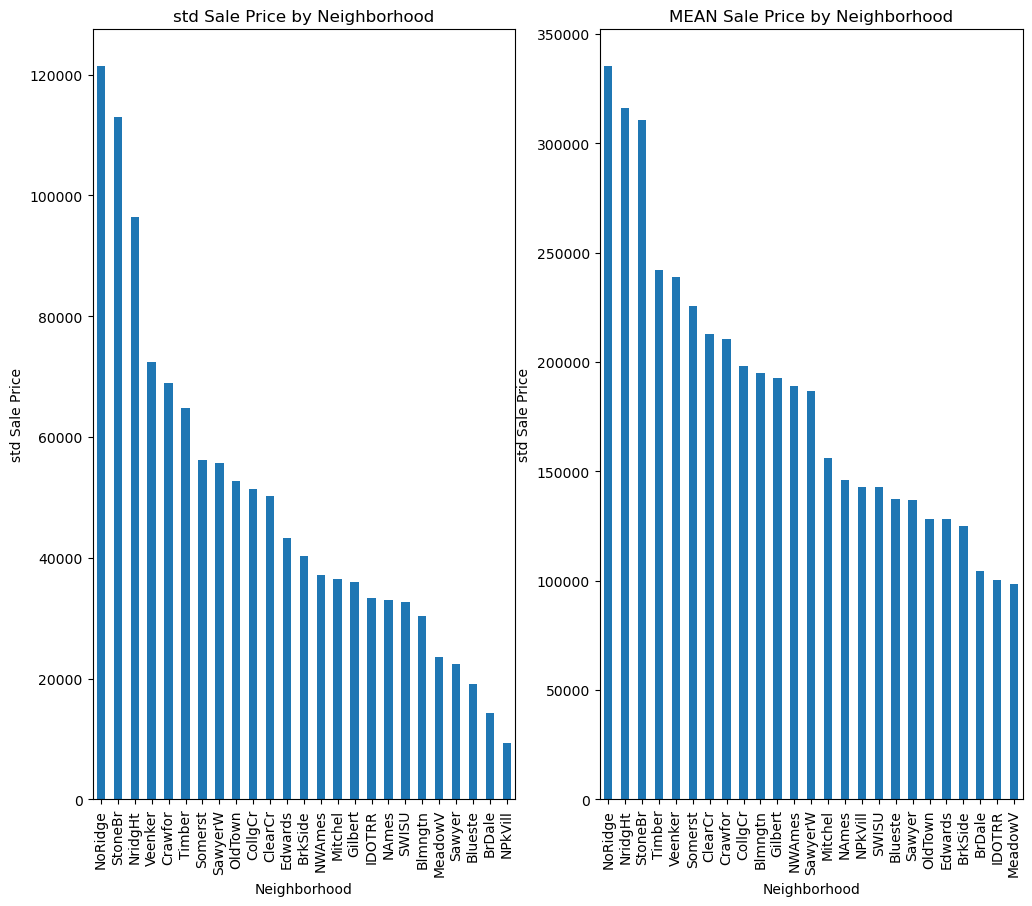

In [44]:
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
col = "Neighborhood"
mean_sale_price_by_zoning = train.groupby(col).std()["SalePrice"]

# Sort the mean "SalePrice" values in descending order
mean_sale_price_by_zoning = mean_sale_price_by_zoning.sort_values(ascending=False)

# Plot the mean "SalePrice" value for each group
mean_sale_price_by_zoning.plot.bar()

# Add a title and labels to the x and y axes
plt.title("std Sale Price by {}".format(col))
plt.xlabel(col)
plt.ylabel("std Sale Price")

# Show the plot
plt.subplot(1,2,2)
col = "Neighborhood"
mean_sale_price_by_zoning = train.groupby(col).mean()["SalePrice"]

# Sort the mean "SalePrice" values in descending order
mean_sale_price_by_zoning = mean_sale_price_by_zoning.sort_values(ascending=False)

# Plot the mean "SalePrice" value for each group
mean_sale_price_by_zoning.plot.bar()

# Add a title and labels to the x and y axes
plt.title("MEAN Sale Price by {}".format(col))
plt.xlabel(col)
plt.ylabel("std Sale Price")

